In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from urllib.request import urlopen
import json
from sodapy import Socrata
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from country_list import countries_for_language
import unidecode
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')


plt.style.use('https://raw.githubusercontent.com/datatrooper/instatrooper/master/styles/w2dt.mplstyle')
dp = [
    "#1c1c3c",
    "#967B4F",
    "#46493D",
    "#839DA5",
    "#9FADAD",
    "#2B4144",
    "#986E37"
]
plt.rcParams['axes.grid'] = False
color = "#424630"

In [2]:
def load_colombia_df():
    client = Socrata("www.datos.gov.co", None)  # https://www.datos.gov.co/es/profile/edit/developer_settings   por si no funciona
    results = client.get("gt2j-8ykr", limit=100000)
    results_df = pd.DataFrame.from_records(results)
    return results_df

In [3]:
def load_muestras_df():
    client = Socrata("www.datos.gov.co", None)  # https://www.datos.gov.co/es/profile/edit/developer_settings   por si no funciona
    results = client.get("8835-5baf", limit=100000)
    results_df = pd.DataFrame.from_records(results)
    return results_df

In [4]:
df_col = load_colombia_df()

In [5]:
df_muestras = load_muestras_df()
df_muestras

,fecha,acumuladas,amazonas,antioquia,arauca,atlantico,bogota,bolivar,boyaca,caldas,...,santander,sucre,tolima,valle_del_cauca,vaupes,vichada,procedencia_desconocida,barranquilla,cartagena,santa_marta
0,Acumulado Feb,601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-05T00:00:00.000,636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-03-06T00:00:00.000,739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-03-07T00:00:00.000,810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-03-08T00:00:00.000,813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,2020-06-09T00:00:00.001,432870,7708,52032,1426,35322,127712,30270,9884,5590,...,12744,3794,6545,38074,791,719,4184,NaN,NaN,NaN
98,2020-06-10T00:00:00.001,444933,7890,54795,1460,10685,129516,2748,10058,5703,...,13045,4029,6920,39071,791,719,5369,25812,27936,9641
99,2020-06-11T00:00:00.001,458324,7960,55998,1475,10990,134280,2867,10186,5914,...,13416,4231,7041,40812,791,719,5422,26943,28833,9690
100,2020-06-12T00:00:00.001,470351,8043,57734,1552,11521,136362,2890,10260,5979,...,14076,4392,7220,42107,791,719,5506,28419,29993,9783


In [6]:
def preprocess_df(df):
    df = df.rename(columns={"fecha_diagnostico": "Fecha de diagnóstico",
                            "ciudad_de_ubicaci_n": "ciudad",
                            "fecha_de_notificaci_n": "Fecha de notificacion",
                            "atenci_n": "atencion"})
    
    df["sexo"] = df["sexo"].str.upper()
    df["estado"] = df["estado"].str.upper()
    df["atencion"] = df["atencion"].str.upper()
    df["tipo"] = df["tipo"].str.upper()
    df["edad"] = df["edad"].astype(int)
    
    df["Fecha de diagnóstico"] = pd.to_datetime(df["Fecha de diagnóstico"], errors="coerce")
    df["fecha_reporte_web"] = pd.to_datetime(df["fecha_reporte_web"], errors="coerce")
    
    df["fecha_recuperado"] = pd.to_datetime(df["fecha_recuperado"], errors="coerce")
    df["fecha_de_muerte"] = pd.to_datetime(df["fecha_de_muerte"], errors="coerce")
    df.loc[df["fis"]=="Asintomático", "estado"] = "ASINTOMATICO"
    df["fis"] = pd.to_datetime(df["fis"], errors="coerce")
    df["tiempo recuperacion"] = df["fecha_recuperado"] - df["fis"]
    df["tiempo recuperacion"] = df["tiempo recuperacion"].dt.days
    
    df["tiempo muerte"] = df["fecha_de_muerte"] - df["fis"]
    df["tiempo muerte"] = df["tiempo muerte"].dt.days
    return df

In [7]:
df_col = preprocess_df(df_col)

In [8]:
df_ant = df_col[df_col["departamento"] == "Valle del Cauca"]

## Generales

In [9]:
max_day = df_ant["fecha_reporte_web"].max()
ultimo_dia = df_ant[df_ant["fecha_reporte_web"] == max_day]
nuevos_inf = ultimo_dia.shape[0]
nuevos_muertos = df_ant[df_ant["fecha_de_muerte"] == "2020-06-13"].shape[0]
nuevos_recuperados = df_ant[df_ant["fecha_recuperado"] == "2020-06-13"].shape[0]

infectados_totales = df_ant.shape[0]

recuperados_totales = df_ant["atencion"].value_counts()["RECUPERADO"]
fallecidos_totales = df_ant["atencion"].value_counts()["FALLECIDO"]
uci = df_ant["atencion"].value_counts()["HOSPITAL UCI"]
hospital = df_ant["atencion"].value_counts()["HOSPITAL"]
activos_totales = df_ant[df_ant["atencion"].isin(["CASA", "HOSPITAL", "HOSPITAL UCI"])].shape[0]

print(f"""
nuevos infectados: {nuevos_inf}
nuevos muertos: {nuevos_muertos}
nuevos recuperados: {nuevos_recuperados}
infectados totales: {infectados_totales}
recuperados totales: {recuperados_totales}
fallecidos totales: {fallecidos_totales}
uci: {uci}
hospital: {hospital}
activos totales: {activos_totales}
""")


nuevos infectados: 152
nuevos muertos: 1
nuevos recuperados: 10
infectados totales: 4690
recuperados totales: 1858
fallecidos totales: 199
uci: 104
hospital: 397
activos totales: 2629



## Infectados

In [10]:
cuenta = pd.DataFrame(df_ant.groupby("Fecha de diagnóstico")["id_de_caso"].count()).reset_index()
cuenta = cuenta.rename(columns={"id_de_caso":"cuenta"})
idx = pd.date_range(cuenta["Fecha de diagnóstico"].min(), cuenta["Fecha de diagnóstico"].max())
all_dates = pd.DataFrame(idx, columns=["fecha"])
cuenta = all_dates.merge(cuenta, left_on="fecha", 
                right_on="Fecha de diagnóstico", 
                how="left").drop("Fecha de diagnóstico", axis=1).fillna(0)
cuenta["fecha"] = cuenta["fecha"].dt.strftime('%m-%d')

In [11]:
cuenta["cuenta"].sum()

4644.0

In [12]:
cuenta[cuenta["fecha"] == "05-11"].index[0]

63

In [13]:
cuenta

,fecha,cuenta
0,03-09,1.0
1,03-10,0.0
2,03-11,0.0
3,03-12,0.0
4,03-13,2.0
...,...,...
92,06-09,125.0
93,06-10,130.0
94,06-11,284.0
95,06-12,76.0


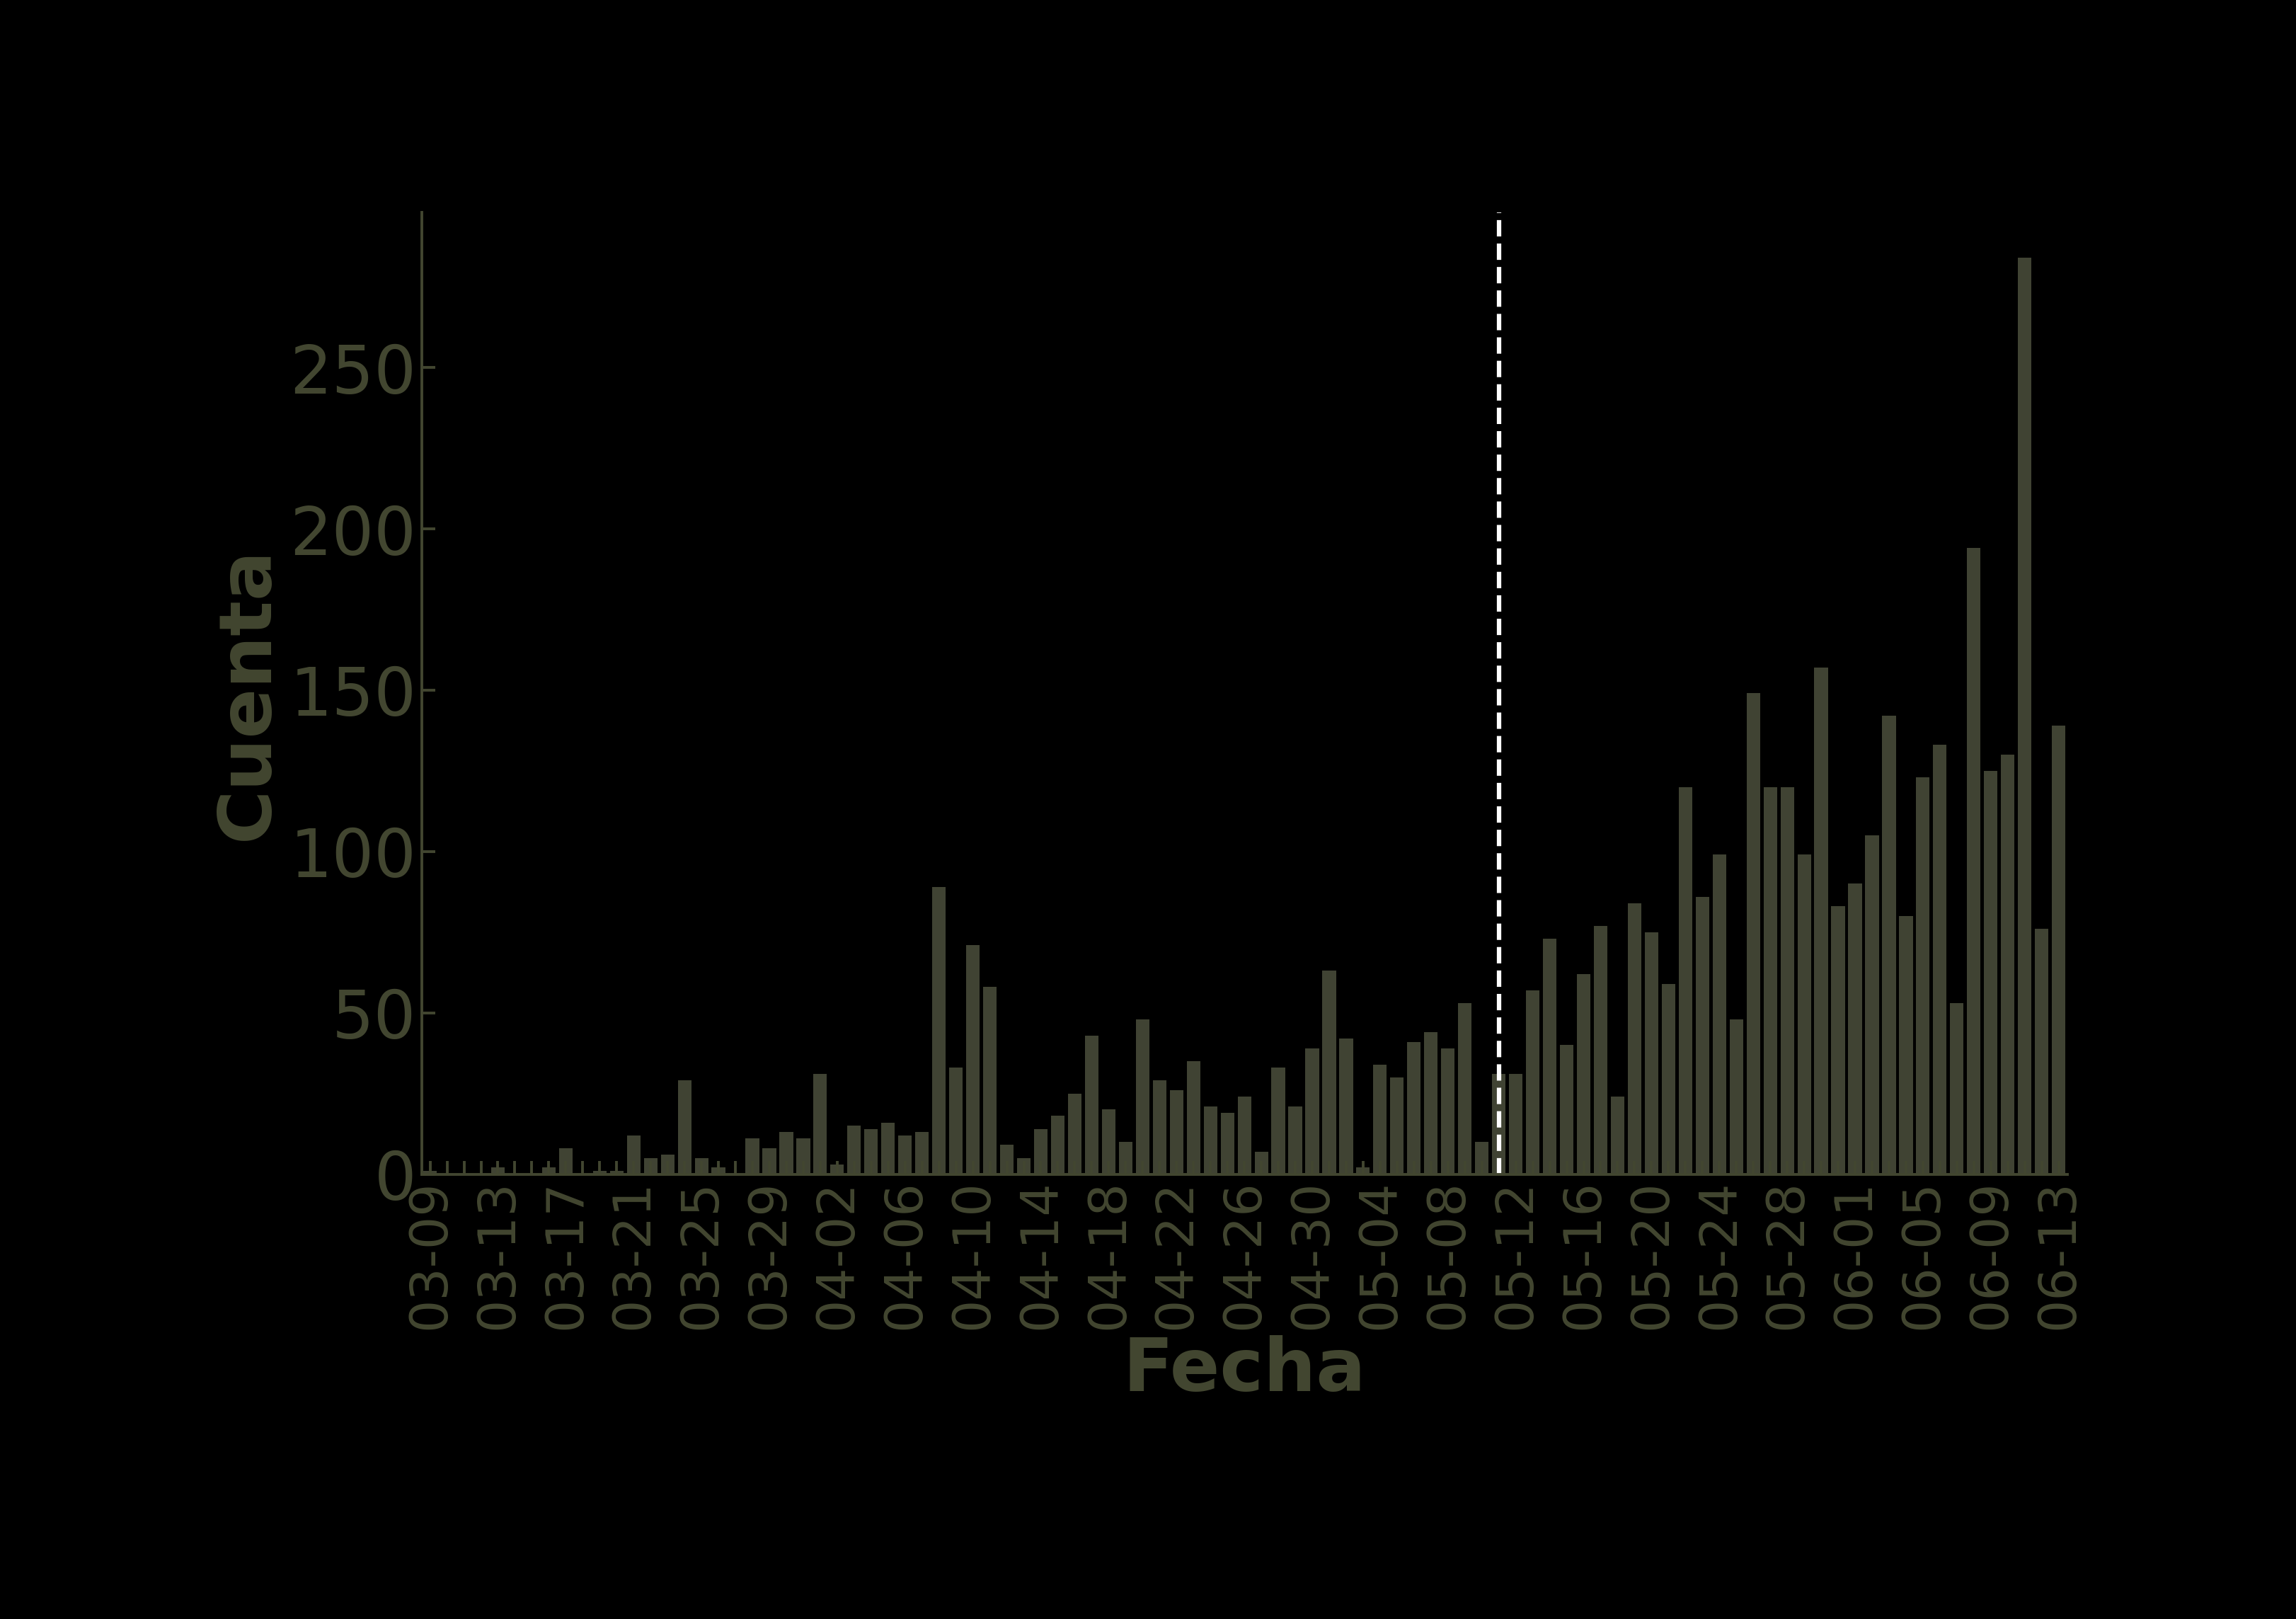

In [14]:
plt.rcParams['axes.labelweight'] = 'bold'
cuenta_plot = cuenta.reset_index(drop=True)
sns.set_context("talk")
plt.figure(figsize=(20,12))
ax = sns.barplot(x="fecha", y="cuenta", data=cuenta_plot, color=color)


ax.tick_params(axis='x',which = "major", colors=color, labelsize=35, labelrotation=90)
ax.tick_params(axis='y', colors=color, labelsize=45)

plt.setp(ax.spines.values(), color=color)

plt.axvline(cuenta_plot[cuenta_plot["fecha"] == "05-11"].index[0], color="white", linestyle='--', linewidth=3)

ax.set_xlabel("Fecha", fontsize=50, color=color)
ax.set_ylabel("Cuenta", fontsize=50, color=color)

for i,label in enumerate(ax.get_xticklabels()):
    if i%4 == 0:
        pass
    else:
        label.set_visible(False)



plt.savefig(f'confirmados_dia.png',bbox_inches='tight', transparent="True", pad_inches = 0)
plt.show()

## Infectados por web

## Numero de pruebas 

### Antioquia

In [15]:
df_muestras_ant = df_muestras.loc[:,["fecha", "valle_del_cauca"]]
df_muestras_ant = df_muestras_ant[df_muestras_ant["valle_del_cauca"].notnull()]
df_muestras_ant["fecha"] = pd.to_datetime(df_muestras_ant["fecha"])
df_muestras_ant["fecha"] = df_muestras_ant["fecha"].dt.strftime('%m-%d')
df_muestras_ant["valle_del_cauca"] = df_muestras_ant["valle_del_cauca"].astype(int)
df_muestras_ant["cuenta"] = df_muestras_ant["valle_del_cauca"].diff()
df_muestras_ant

,fecha,valle_del_cauca,cuenta
67,05-10,16447,NaN
68,05-11,16618,171.0
69,05-12,17276,658.0
70,05-13,17689,413.0
71,05-14,18016,327.0
72,05-15,18678,662.0
73,05-16,19360,682.0
74,05-17,19913,553.0
75,05-18,20382,469.0
76,05-19,20768,386.0


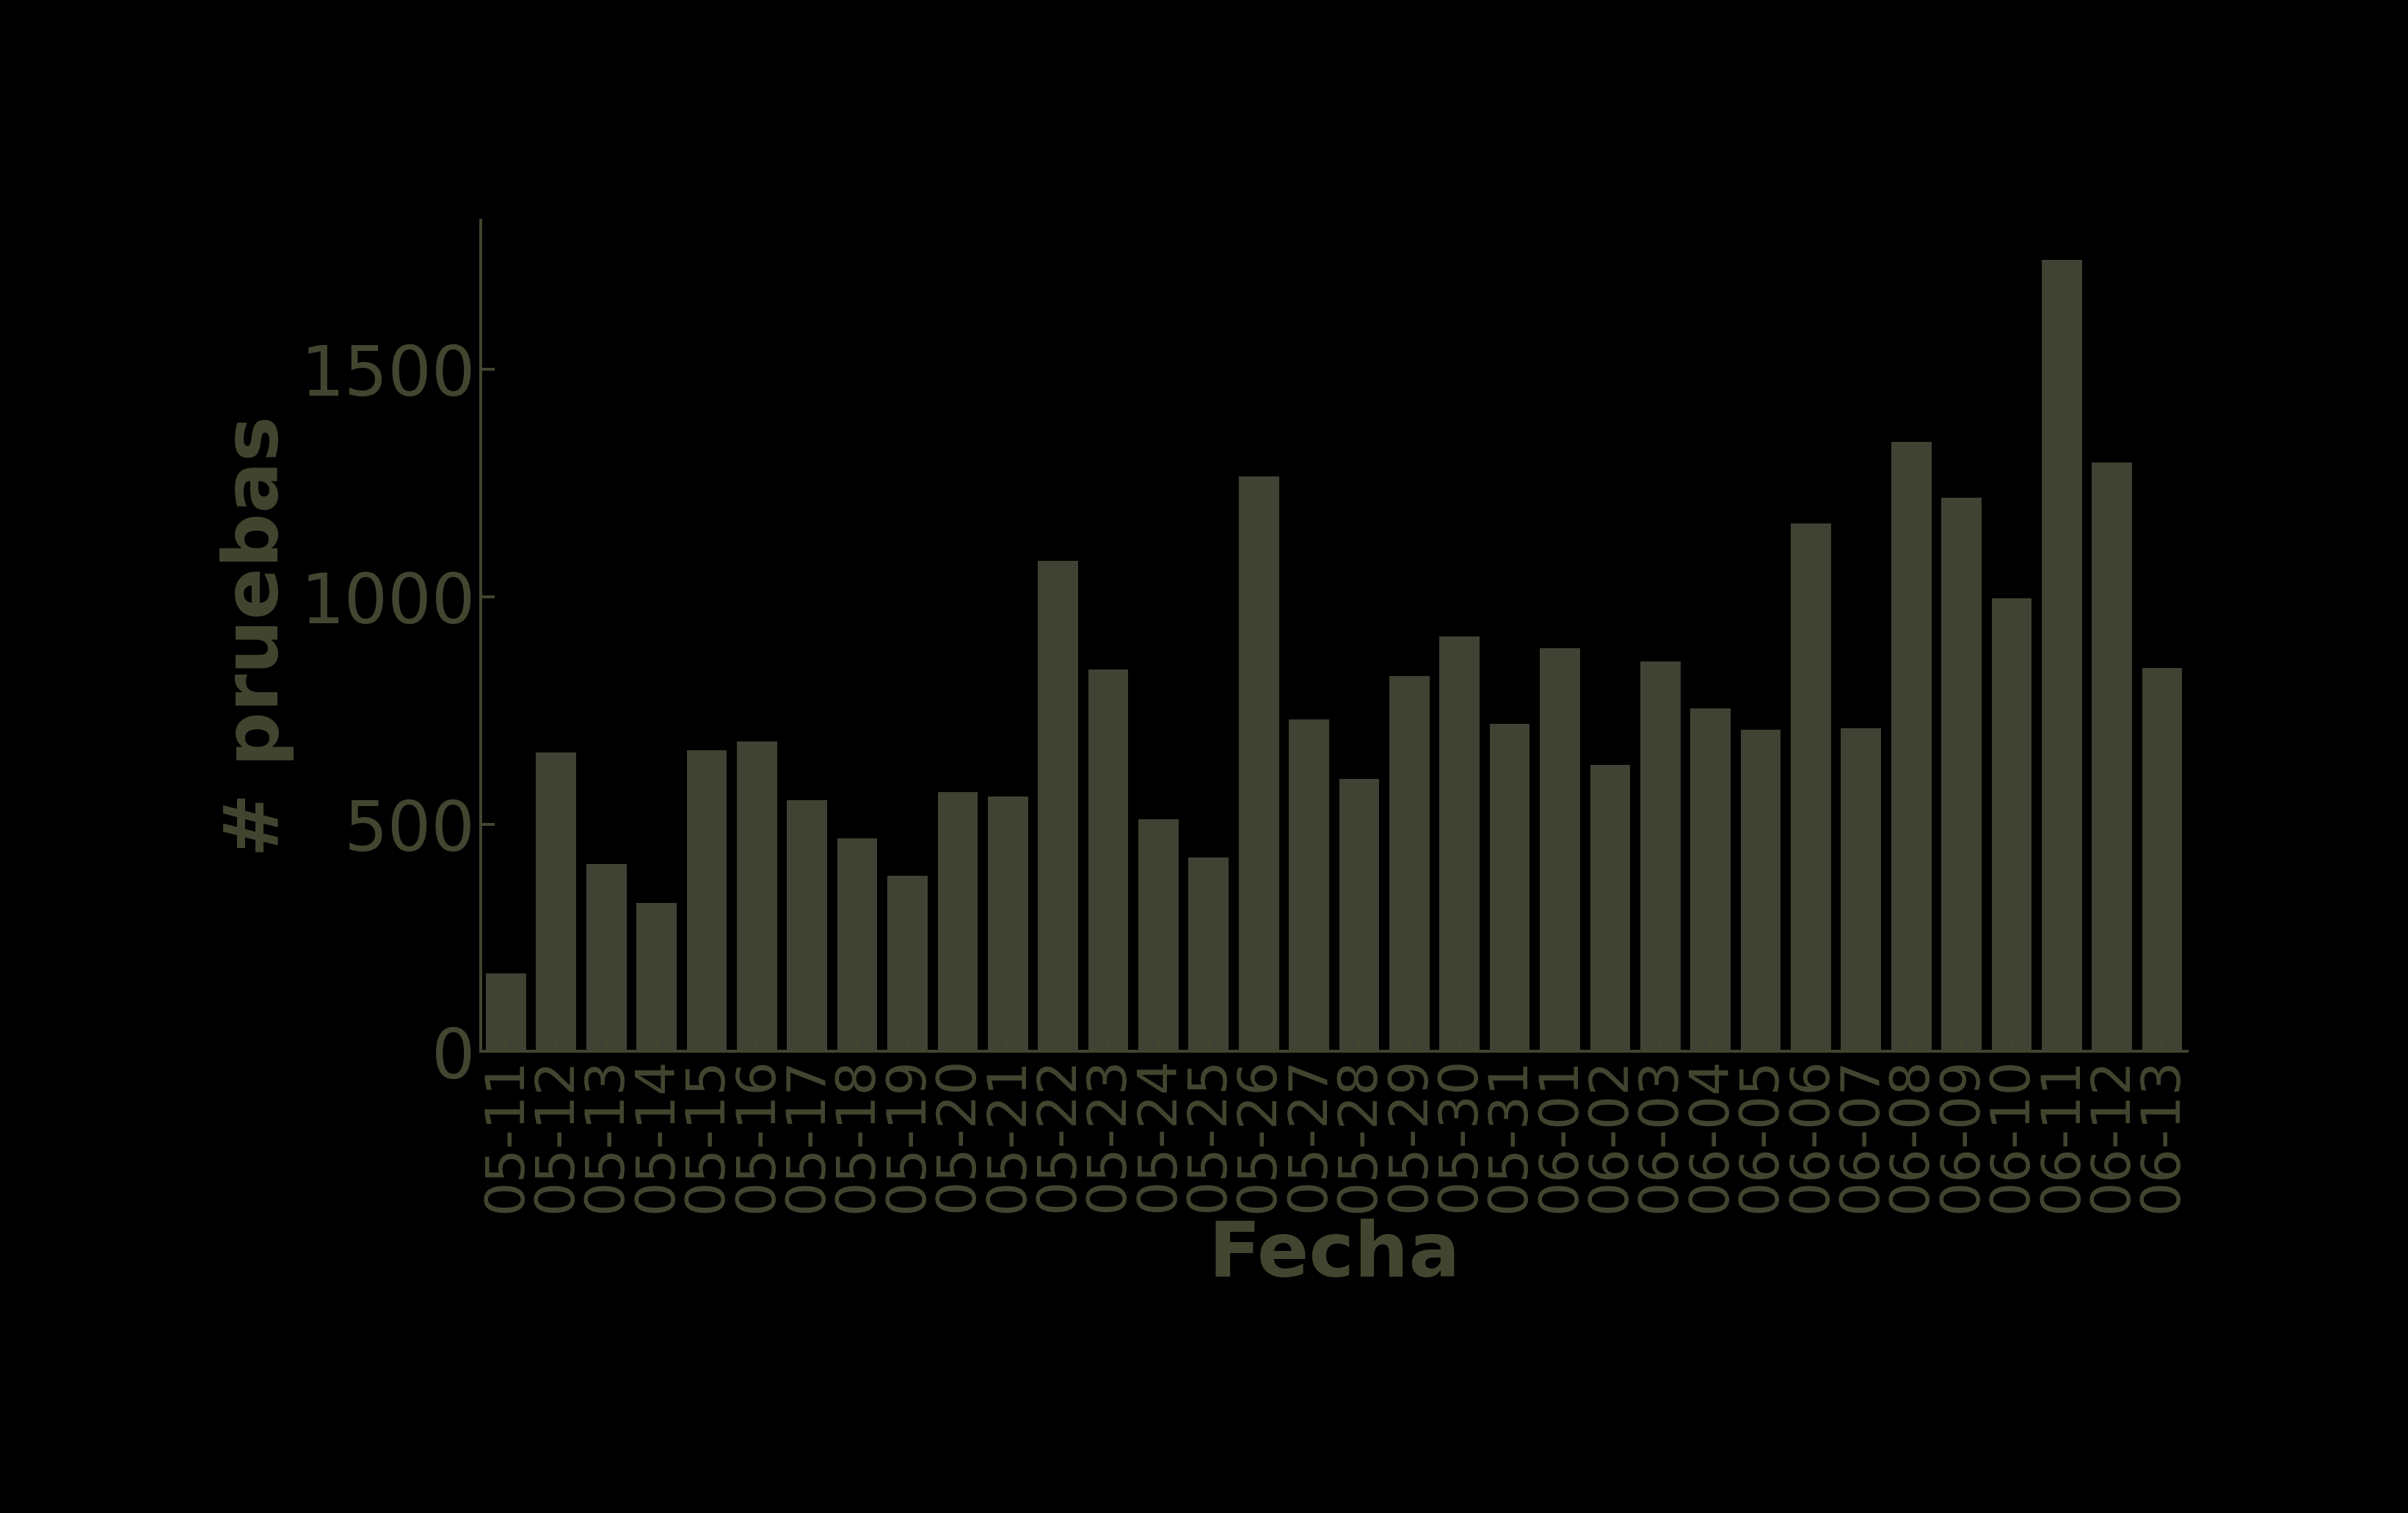

In [16]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x="fecha", y="cuenta", data=df_muestras_ant[1:], color=color)
plt.xticks(rotation=90, fontsize=25)
plt.yticks(fontsize=25)

ax.tick_params(axis='x',which = "major", colors=color, labelsize=35, labelrotation=90)
ax.tick_params(axis='y', colors=color, labelsize=45)

ax.set_xlabel("Fecha", fontsize=50, color=color)
ax.set_ylabel("# pruebas", fontsize=50, color=color)
plt.setp(ax.spines.values(), color=color)


plt.savefig(f'muestras_dia.png',bbox_inches='tight', transparent="True", pad_inches = 0)
plt.show()

## Recuperados

In [17]:
df_ant_changed = df_ant.copy()
df_ant_changed["fecha_recuperado"] = df_ant_changed["fecha_recuperado"].dropna()
cuenta_rec = pd.DataFrame(df_ant_changed.groupby("fecha_recuperado")["id_de_caso"].count()).reset_index()

cuenta_rec = cuenta_rec.rename(columns={"id_de_caso":"cuenta"})

idx = pd.date_range(cuenta_rec["fecha_recuperado"].min(), cuenta_rec["fecha_recuperado"].max())
all_dates = pd.DataFrame(idx, columns=["fecha"])
cuenta_rec = all_dates.merge(cuenta_rec, left_on="fecha", 
                right_on="fecha_recuperado", 
                how="left").drop("fecha_recuperado", axis=1).fillna(0)
cuenta_rec["fecha"] = cuenta_rec["fecha"].dt.strftime('%m-%d')
cuenta_rec.tail()

,fecha,cuenta
82,06-09,39.0
83,06-10,55.0
84,06-11,18.0
85,06-12,51.0
86,06-13,10.0


In [18]:
cuenta_rec["cuenta"].sum()

1848.0

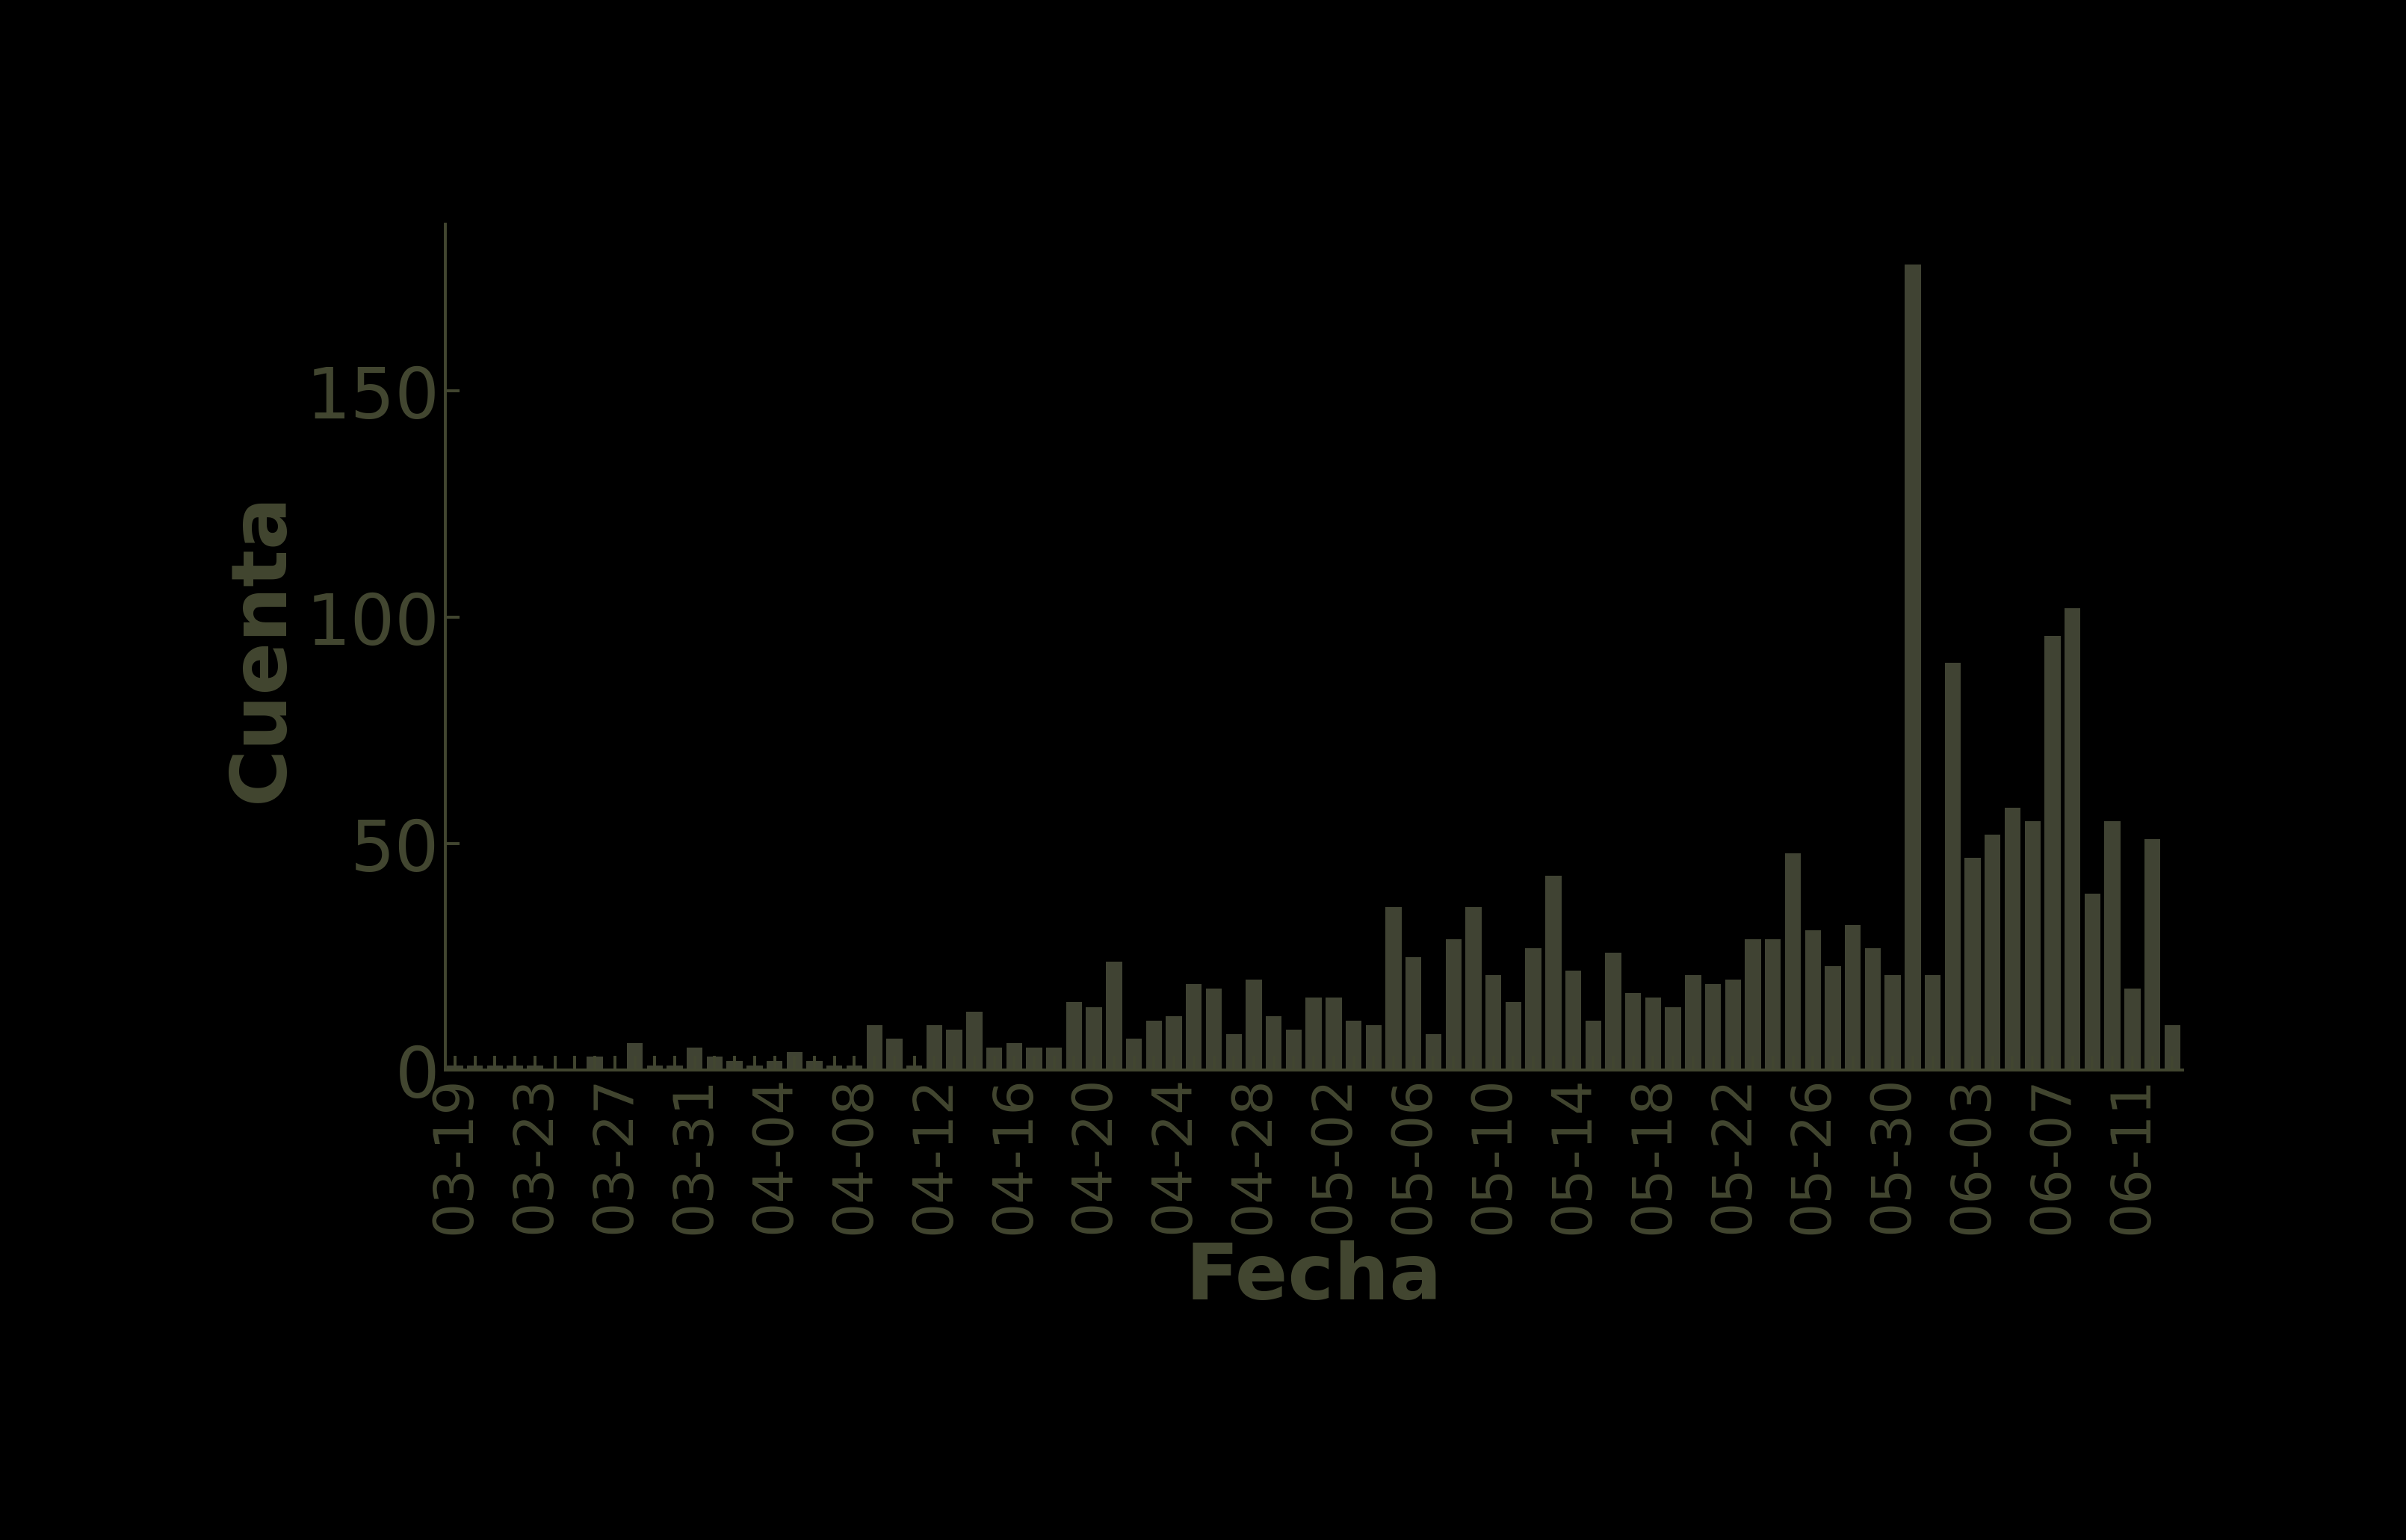

In [19]:
sns.set_context("talk")
cuenta_plot = cuenta_rec.reset_index(drop=True)
plt.figure(figsize=(20,10))
ax = sns.barplot(x="fecha", y="cuenta", data=cuenta_plot, color=color)
plt.xticks(rotation=90, fontsize=25)
plt.yticks(fontsize=25)
ax.tick_params(axis='x',which = "major", colors=color, labelsize=35, labelrotation=90)
ax.tick_params(axis='y', colors=color, labelsize=45)
plt.setp(ax.spines.values(), color=color)

ax.set_xlabel("Fecha", fontsize=50, color=color)
ax.set_ylabel("Cuenta", fontsize=50, color=color)
for i,label in enumerate(ax.get_xticklabels()):
    if i%4 == 0:
        pass
    else:
        label.set_visible(False)
plt.savefig(f'recuperados_dia.png',bbox_inches='tight', transparent="True", pad_inches = 0)
plt.show()

In [20]:
df_ant[df_ant["estado"] == "FALLECIDO"]

,id_de_caso,Fecha de notificacion,c_digo_divipola,ciudad,departamento,atencion,edad,sexo,tipo,estado,...,fis,Fecha de diagnóstico,fecha_recuperado,fecha_reporte_web,tipo_recuperaci_n,codigo_departamento,codigo_pais,fecha_de_muerte,tiempo recuperacion,tiempo muerte
187,188,2020-03-17T00:00:00.000,76001,Cali,Valle del Cauca,FALLECIDO,70,F,RELACIONADO,FALLECIDO,...,2020-03-08,2020-03-21,NaT,2020-03-21,NaN,76,NaN,2020-03-22,NaN,14.0
281,282,2020-03-20T00:00:00.000,76001,Cali,Valle del Cauca,FALLECIDO,40,M,IMPORTADO,FALLECIDO,...,2020-03-14,2020-03-23,NaT,2020-03-23,NaN,76,840,2020-04-15,NaN,32.0
424,425,2020-03-21T00:00:00.000,76001,Cali,Valle del Cauca,FALLECIDO,80,F,RELACIONADO,FALLECIDO,...,2020-03-18,2020-03-25,NaT,2020-03-25,NaN,76,NaN,2020-04-04,NaN,17.0
542,543,2020-03-26T00:00:00.000,76001,Cali,Valle del Cauca,FALLECIDO,51,M,RELACIONADO,FALLECIDO,...,2020-03-15,2020-03-28,NaT,2020-03-28,NaN,76,NaN,2020-03-30,NaN,15.0
618,619,2020-03-28T00:00:00.000,76001,Cali,Valle del Cauca,FALLECIDO,36,M,RELACIONADO,FALLECIDO,...,2020-03-18,2020-03-29,NaT,2020-03-29,NaN,76,NaN,2020-03-25,NaN,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41136,41177,2020-06-03T00:00:00.000,76001,Cali,Valle del Cauca,FALLECIDO,77,M,EN ESTUDIO,FALLECIDO,...,2020-06-02,2020-06-09,NaT,2020-06-09,NaN,76,NaN,2020-06-02,NaN,0.0
42076,42117,2020-03-26T00:00:00.000,76248,El Cerrito,Valle del Cauca,FALLECIDO,39,M,RELACIONADO,FALLECIDO,...,2020-03-25,2020-06-09,NaT,2020-06-09,NaN,76,NaN,2020-04-02,NaN,8.0
43189,43230,2020-06-07T00:00:00.000,76001,Cali,Valle del Cauca,FALLECIDO,92,M,EN ESTUDIO,FALLECIDO,...,2020-06-01,2020-06-10,NaT,2020-06-10,NaN,76,NaN,2020-06-10,NaN,9.0
44505,44546,2020-06-04T00:00:00.000,76001,Cali,Valle del Cauca,FALLECIDO,62,F,EN ESTUDIO,FALLECIDO,...,2020-05-28,2020-06-11,NaT,2020-06-11,NaN,76,NaN,2020-06-11,NaN,14.0


In [21]:
df_ant["estado"].value_counts()

LEVE            3965
MODERADO         405
FALLECIDO        199
GRAVE            104
ASINTOMÁTICO      14
N/A                3
Name: estado, dtype: int64

In [22]:
df_male = df_ant[df_ant["sexo"] == "M"]
df_female = df_ant[df_ant["sexo"] == "F"]

male_death = df_male[df_male["estado"]=="FALLECIDO"]
female_death = df_female[df_female["estado"]=="FALLECIDO"]

m_cont = df_male.groupby(pd.cut(df_male["edad"], np.arange(0, 100, 4)))["id_de_caso"].count().to_frame("Hombres")
f_cont = df_female.groupby(pd.cut(df_female["edad"], np.arange(0, 100, 4)))["id_de_caso"].count().to_frame("Mujeres")

piramide = m_cont.join(f_cont).reset_index()

piramide["Hombres"] = -piramide["Hombres"]

piramide.head()

,edad,Hombres,Mujeres
0,"(0, 4]",-36,26
1,"(4, 8]",-40,35
2,"(8, 12]",-35,47
3,"(12, 16]",-55,46
4,"(16, 20]",-106,99


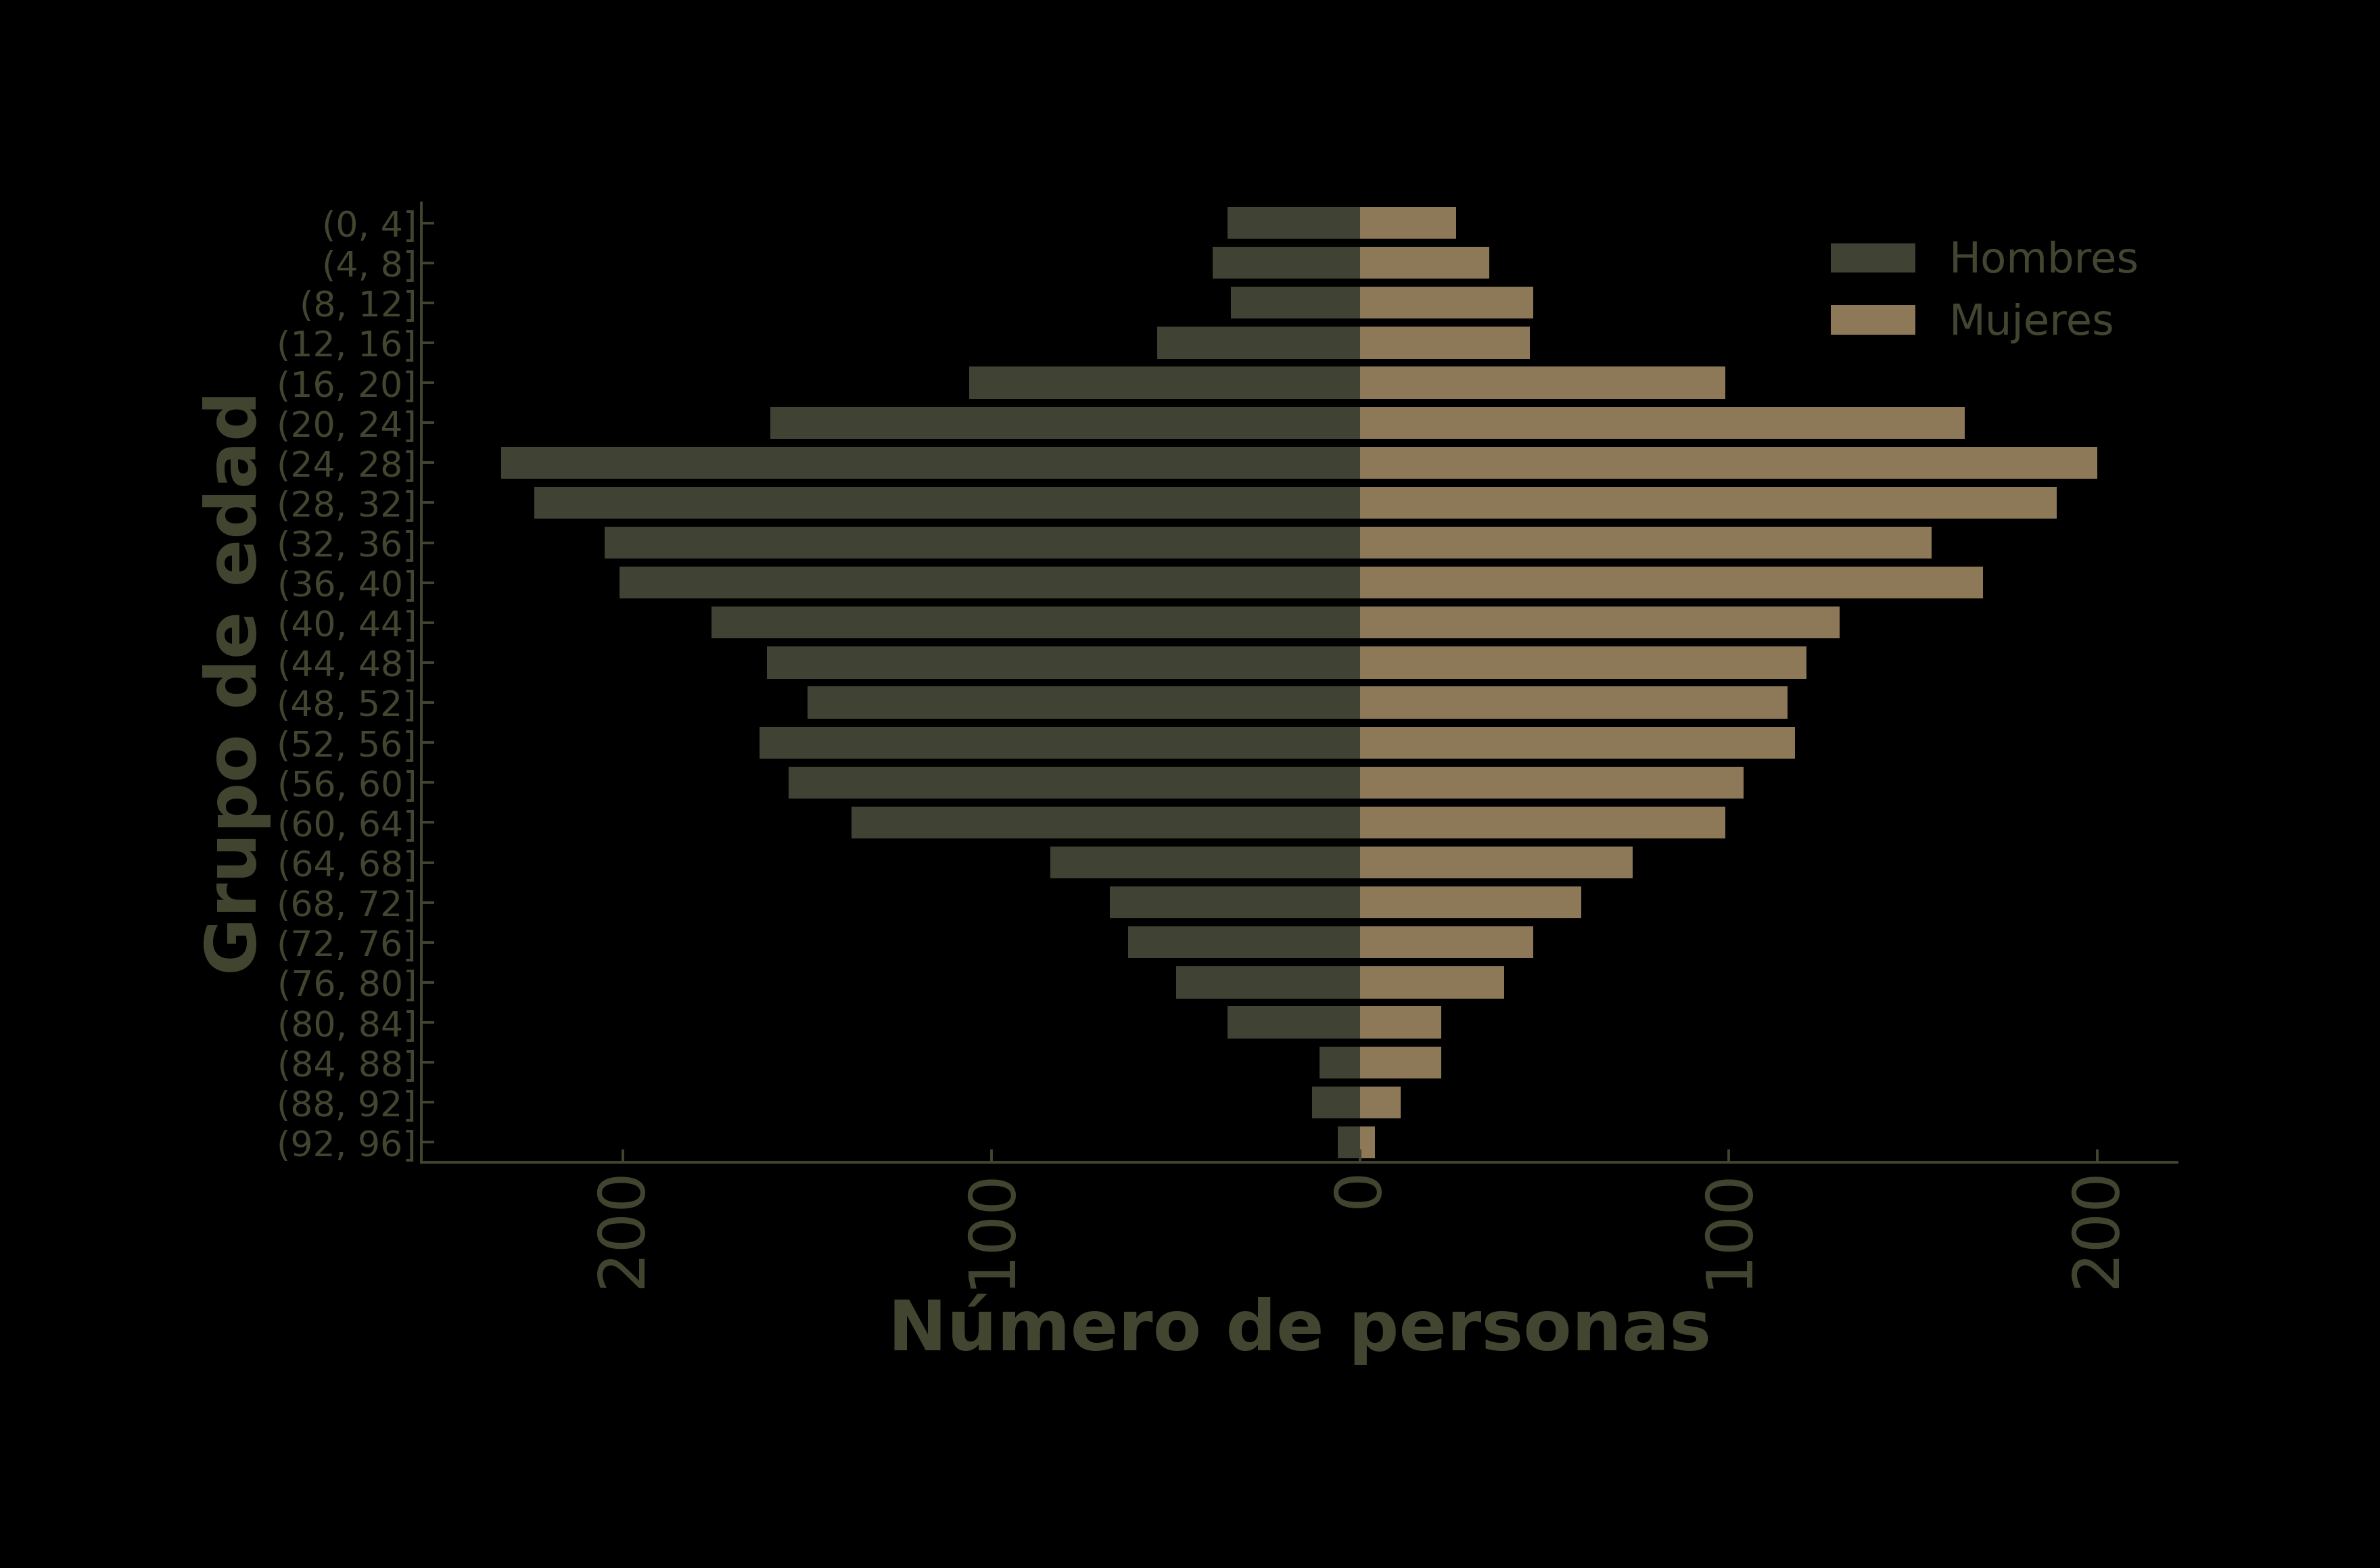

In [23]:
# sns.set_color_codes("pastel")
plt.figure(figsize=(20,12))
ax = sns.barplot(x="Hombres",y="edad", color=color, label="Hombres",data = piramide)

ax = sns.barplot(x="Mujeres",y="edad", color="#967B4F", label="Mujeres",data = piramide)

plt.setp(ax.spines.values(), color=color)


ax.tick_params(axis='x',which = "major", colors=color, labelsize=35, labelrotation=90)
ax.tick_params(axis='y', colors=color, labelsize=45)

ax.set_xlabel("Número de personas", fontsize=50, color=color)
ax.set_ylabel("Grupo de edad", fontsize=50, color=color)


plt.xticks(fontsize=45)
plt.yticks(fontsize=25)

ax.set_xticklabels(np.abs(list(ax.get_xticks())).astype(int))
plt.legend(framealpha=0.0, fontsize=30)

plt.tight_layout()
plt.savefig(f'piramide.png',bbox_inches='tight', transparent="True", pad_inches = 0)

plt.show()

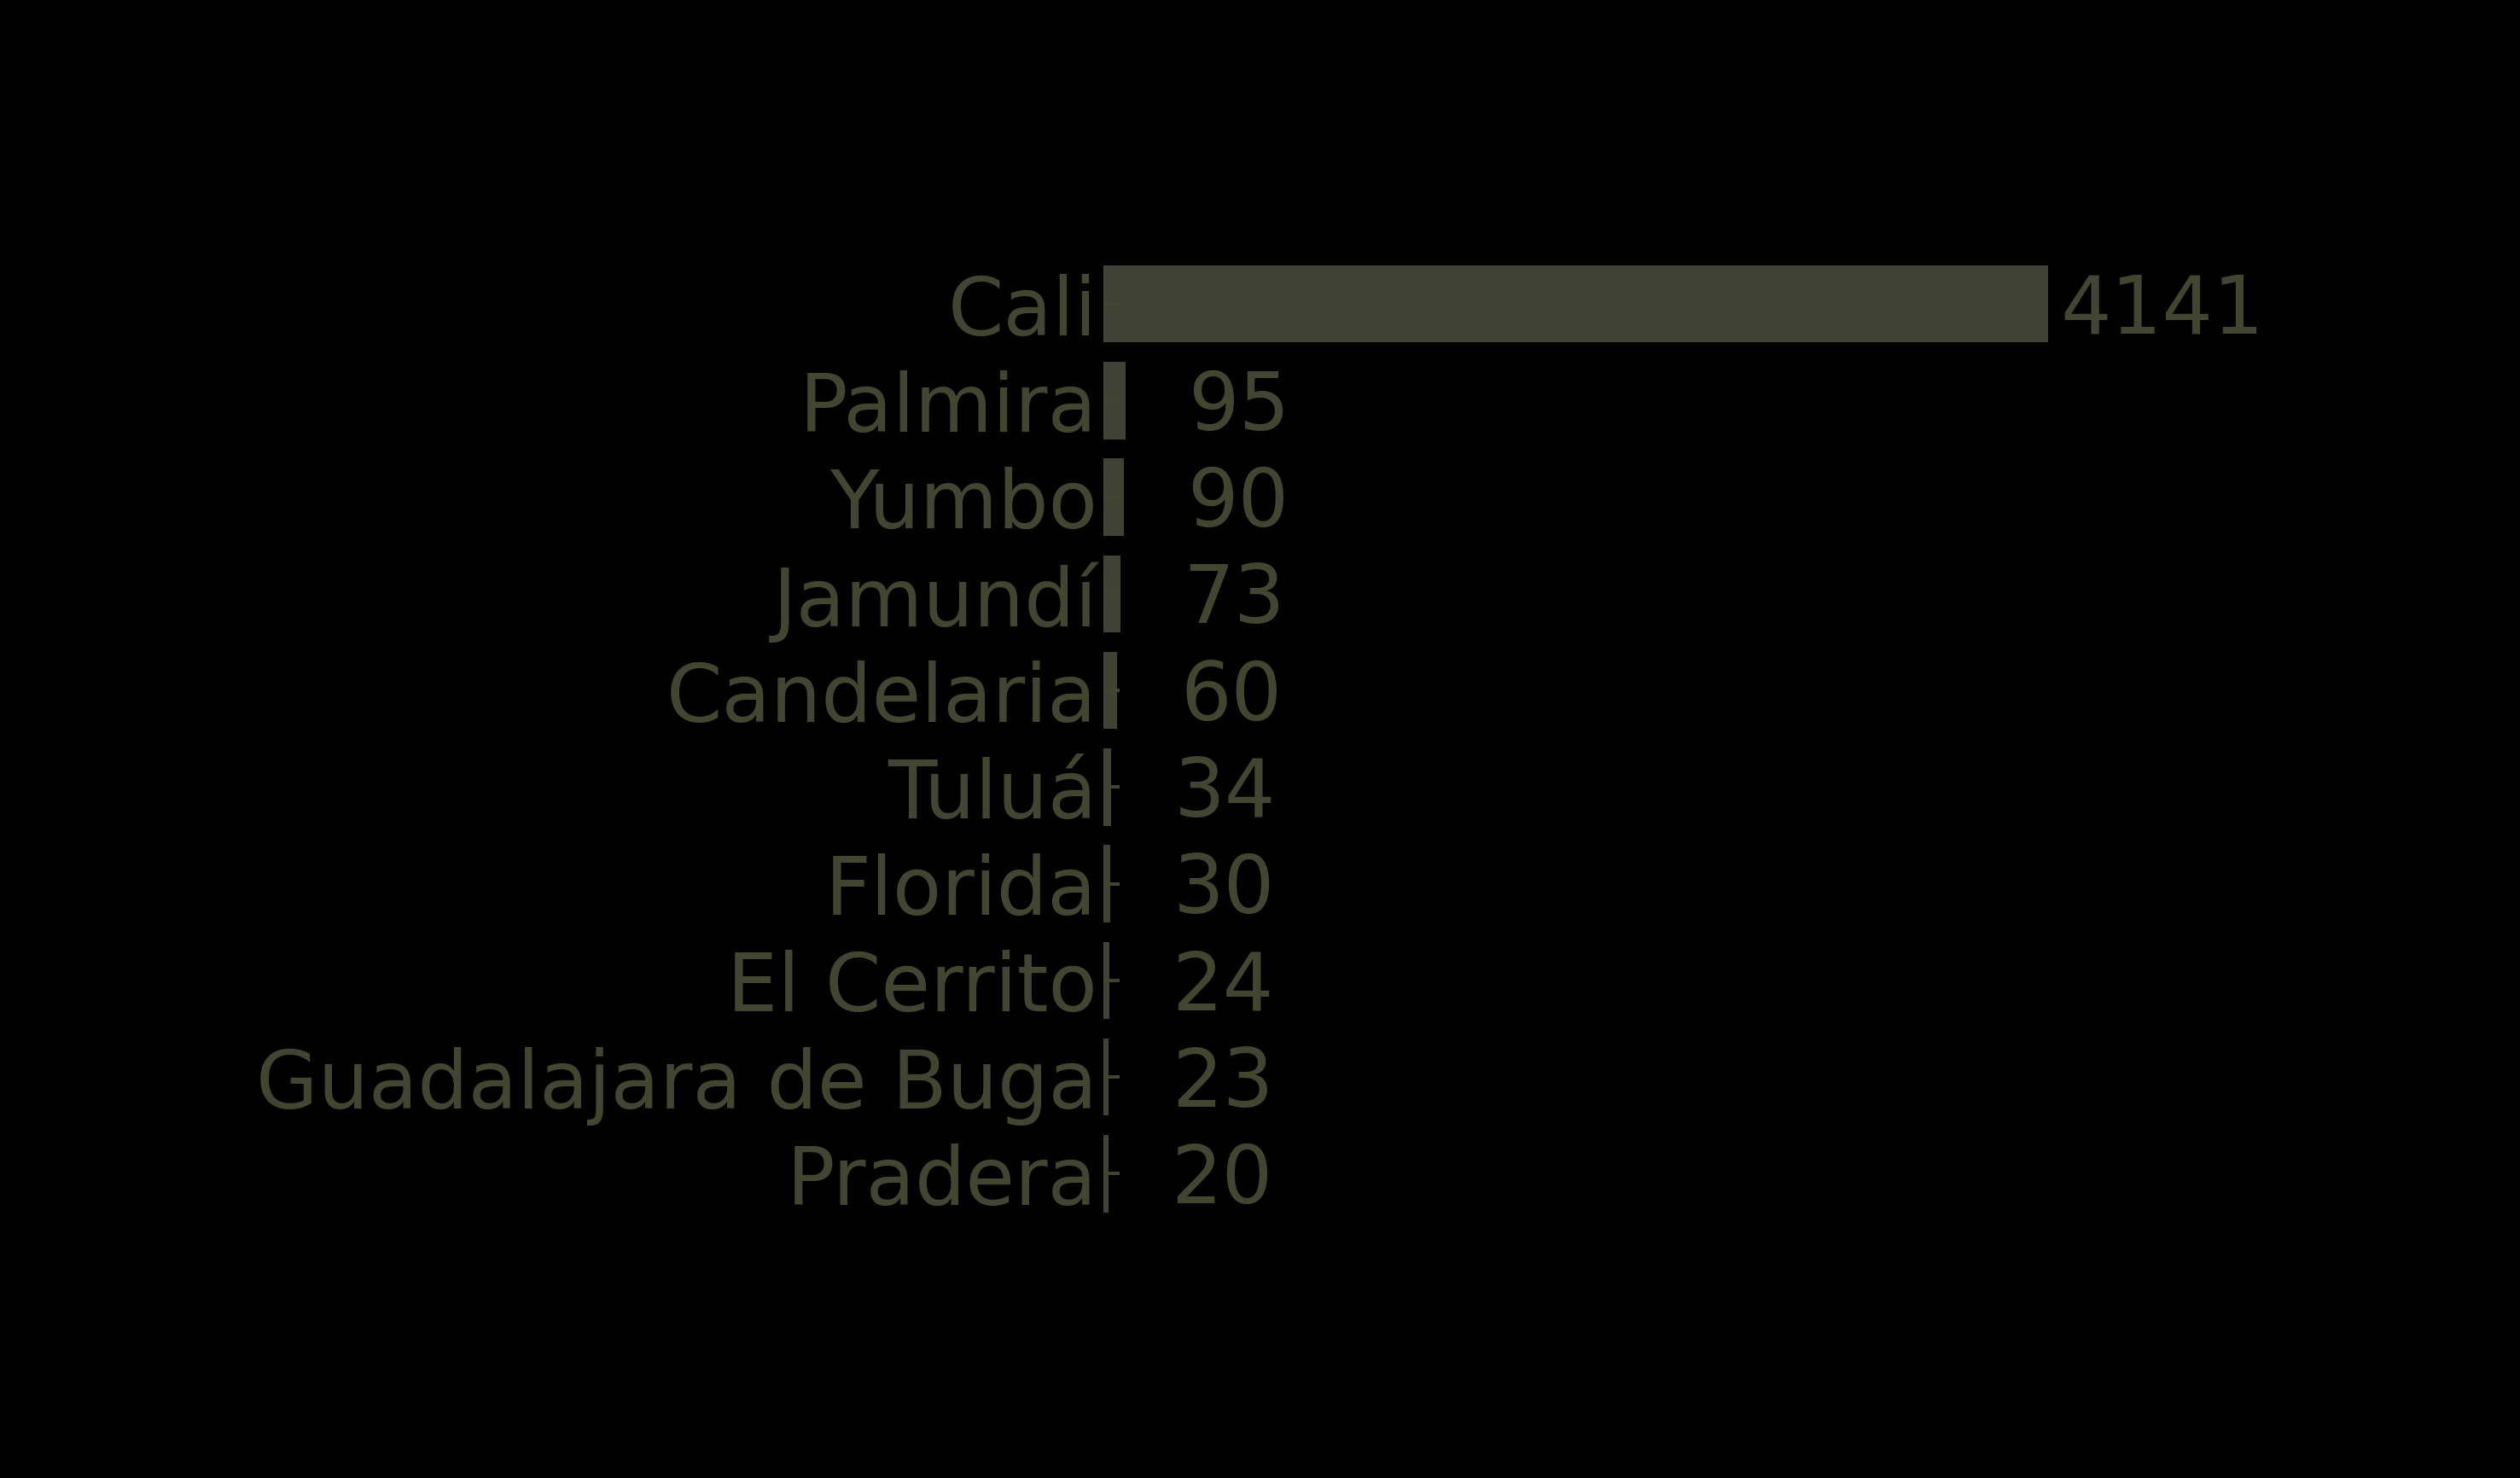

In [24]:
ciudades = df_ant.groupby("ciudad")["id_de_caso"].count().to_frame("cuenta").reset_index()
ciudades = ciudades.sort_values("cuenta", ascending=False).reset_index()
ax = sns.barplot(x = "cuenta", y="ciudad", data=ciudades.head(10), orient="h", color=color)

plt.grid(False)

ax.set_xlabel("", fontsize=30)
plt.xticks([])
plt.box(False)
ax.set_ylabel("", fontsize=30)

ax.tick_params(axis='y',which = "major", colors=color)



# jugar con estos valores
vertical_offset = 0.3
horizontal_offset = 500

ax.tick_params(axis='both', which='major', labelsize=45)
for index, row in ciudades.head(10).iterrows():
    ax.text(row["cuenta"] + horizontal_offset,index+vertical_offset, # posicion
            row["cuenta"], # texto
            color=color, 
            ha="center", 
            size=45)
    
plt.savefig(f'ciudades_antioquia.png',bbox_inches='tight', transparent="True", pad_inches = 0)
plt.show()

# ratio muertes-contagio

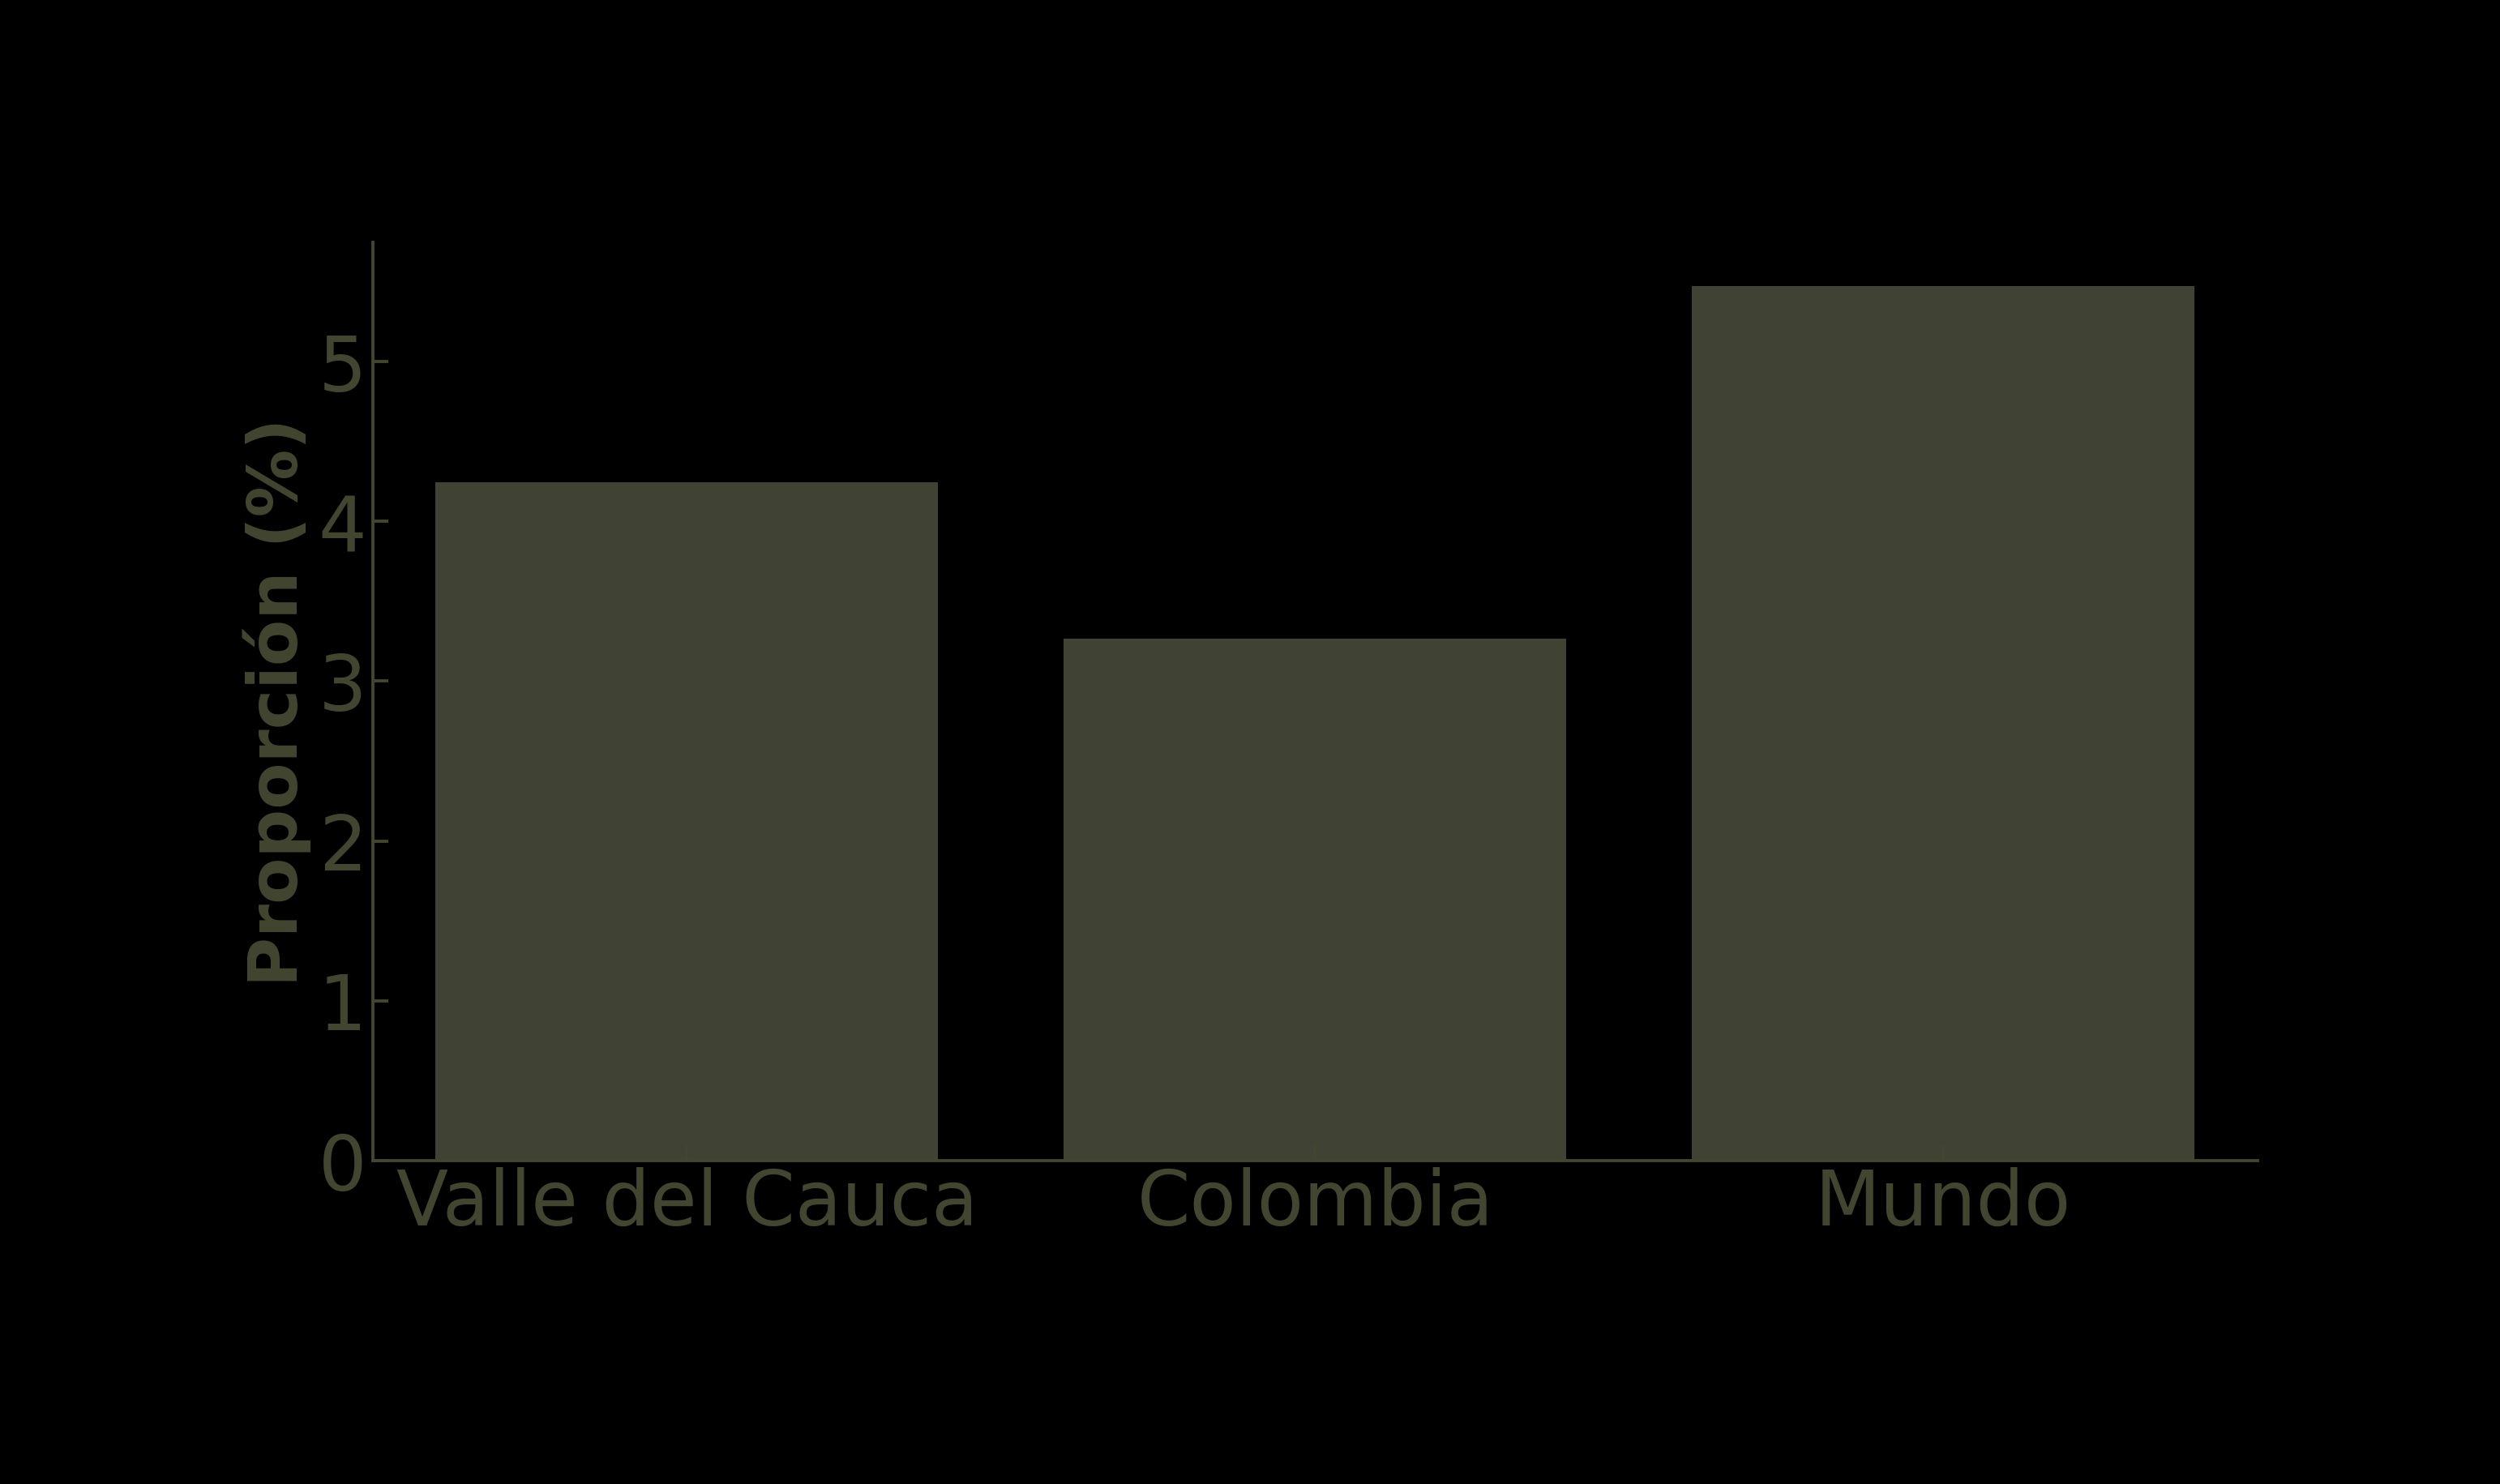

In [25]:
x = ["Valle del Cauca", "Colombia", "Mundo"]
ant_rat = (199/4690) * 100
col_rat = (1592/48746) * 100
world_rat = (433183/7915976) * 100
y = [ant_rat,col_rat,world_rat]
plt.figure(figsize=(20,10))
ax = sns.barplot(x = x, y=y, color=color)

ax.tick_params(axis='x',which = "major", colors=color, labelsize=45)
ax.tick_params(axis='y', colors=color, labelsize=45)
plt.setp(ax.spines.values(), color=color)

ax.set_xlabel("", fontsize=50, color=color)
ax.set_ylabel("Proporción (%)", fontsize=40, color=color)

plt.savefig(f'ratios.png',bbox_inches='tight', transparent="True", pad_inches = 0)
plt.show()

In [26]:
uci

104

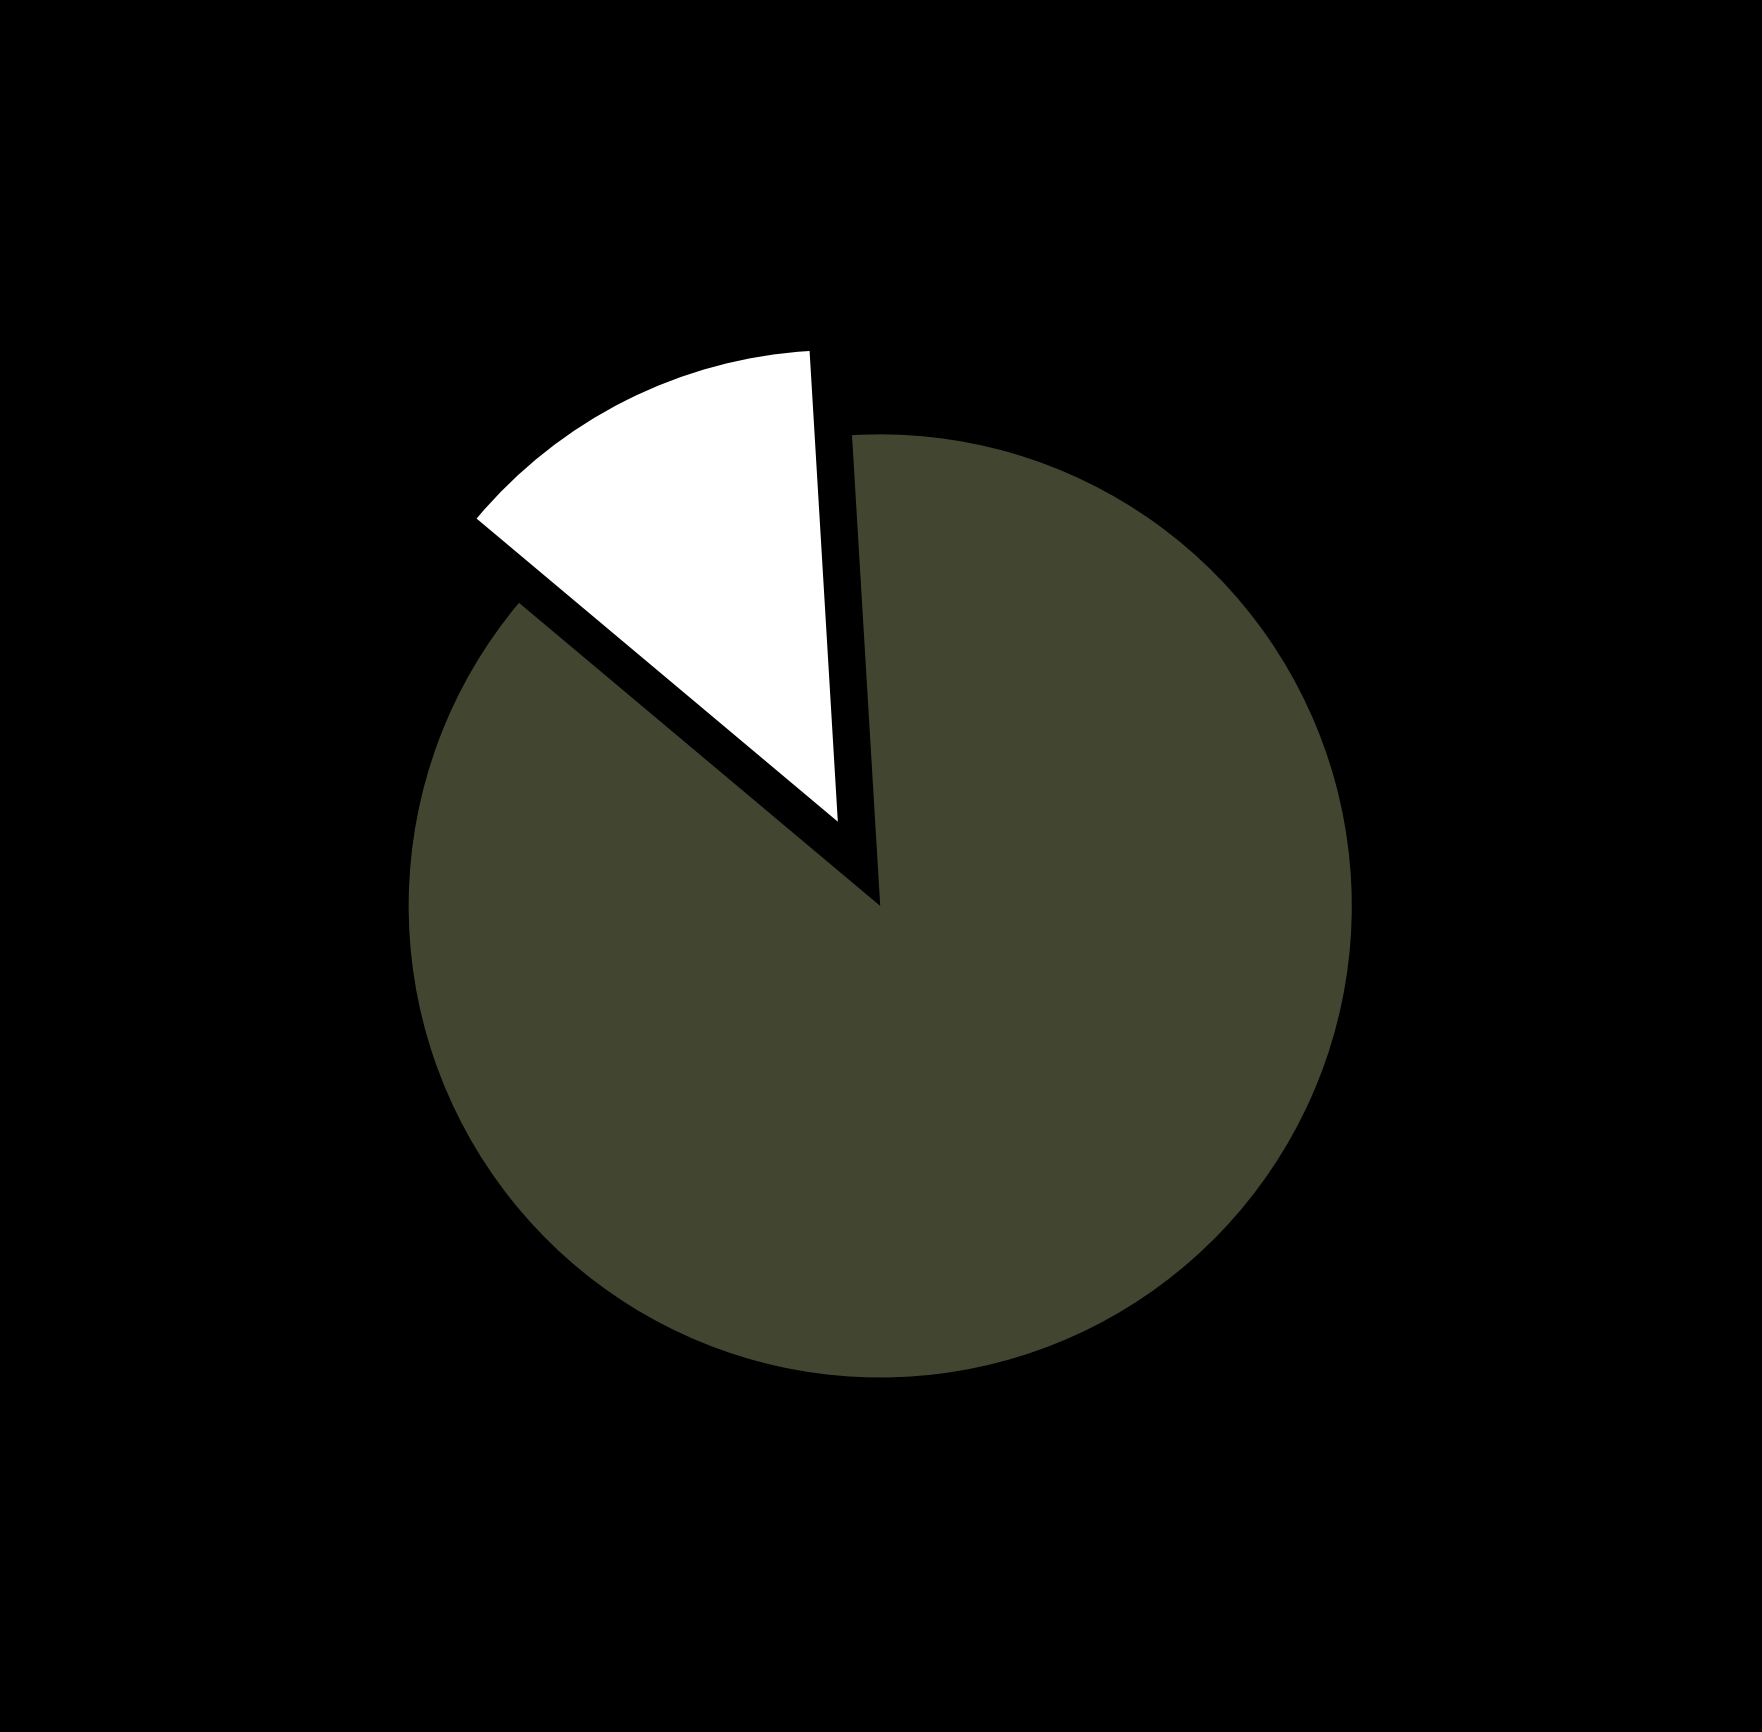

In [27]:
import matplotlib.pyplot as plt

# Data to plot
labels = '', ''
sizes = [804-uci, uci]
colors = [color, "white"]
explode = (0, 0.2)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors, startangle=140)

plt.axis('equal')

plt.savefig(f'instalada.png',bbox_inches='tight', transparent="True", pad_inches = 0)

plt.show()



In [28]:
367+296+6+4+4

677

In [29]:
df_ant["atencion"].value_counts()

CASA            2128
RECUPERADO      1858
HOSPITAL         397
FALLECIDO        199
HOSPITAL UCI     104
N/A                4
Name: atencion, dtype: int64

In [30]:
df_ant["estado"].value_counts()

LEVE            3965
MODERADO         405
FALLECIDO        199
GRAVE            104
ASINTOMÁTICO      14
N/A                3
Name: estado, dtype: int64

In [31]:
df_ant

,id_de_caso,Fecha de notificacion,c_digo_divipola,ciudad,departamento,atencion,edad,sexo,tipo,estado,...,fis,Fecha de diagnóstico,fecha_recuperado,fecha_reporte_web,tipo_recuperaci_n,codigo_departamento,codigo_pais,fecha_de_muerte,tiempo recuperacion,tiempo muerte
1,2,2020-03-06T00:00:00.000,76111,Guadalajara de Buga,Valle del Cauca,RECUPERADO,34,M,IMPORTADO,LEVE,...,2020-03-04,2020-03-09,2020-03-19,2020-03-09,PCR,76,724,NaT,15.0,NaN
13,14,2020-03-10T00:00:00.000,76520,Palmira,Valle del Cauca,RECUPERADO,48,M,IMPORTADO,LEVE,...,2020-03-07,2020-03-13,2020-03-21,2020-03-13,PCR,76,724,NaT,14.0,NaN
24,25,2020-03-13T00:00:00.000,76001,Cali,Valle del Cauca,RECUPERADO,49,M,IMPORTADO,LEVE,...,2020-03-10,2020-03-13,2020-05-12,2020-03-13,PCR,76,724,NaT,63.0,NaN
61,62,2020-03-14T00:00:00.000,76001,Cali,Valle del Cauca,RECUPERADO,32,M,IMPORTADO,LEVE,...,2020-03-12,2020-03-16,2020-03-26,2020-03-16,PCR,76,380,NaT,14.0,NaN
62,63,2020-03-16T00:00:00.000,76001,Cali,Valle del Cauca,RECUPERADO,26,F,IMPORTADO,LEVE,...,2020-03-14,2020-03-16,2020-03-28,2020-03-16,PCR,76,250,NaT,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48017,48058,2020-06-08T00:00:00.000,76001,Cali,Valle del Cauca,CASA,31,F,EN ESTUDIO,LEVE,...,2020-06-07,2020-06-12,NaT,2020-06-13,NaN,76,NaN,NaT,NaN,NaN
48018,48059,2020-06-06T00:00:00.000,76001,Cali,Valle del Cauca,CASA,38,M,EN ESTUDIO,LEVE,...,2020-06-04,2020-06-12,NaT,2020-06-13,NaN,76,NaN,NaT,NaN,NaN
48019,48060,2020-06-05T00:00:00.000,76001,Cali,Valle del Cauca,CASA,38,F,EN ESTUDIO,LEVE,...,2020-06-01,2020-06-12,NaT,2020-06-13,NaN,76,NaN,NaT,NaN,NaN
48020,48061,2020-06-09T00:00:00.000,76001,Cali,Valle del Cauca,CASA,38,M,EN ESTUDIO,LEVE,...,2020-06-01,2020-06-12,NaT,2020-06-13,NaN,76,NaN,NaT,NaN,NaN
